## TD(0)

The simplest TD learning rule is the TD(0) rule -- an update of the value at just a short time in the past ($t-\Delta t$, so $\theta = \Delta t $) using only the current reward rate.
In discrete-time settings, the TD(0) error is
$$\delta_t^{(0)} = R_t + \gamma V(s_{t+1}) - V(s_t) $$


In continuous time RL, TD(0) is a bit different. An update with only the instantaneous reward rate is given by
 \begin{align}
 \delta^{(0)}(t) = r(t) + \log(\gamma) V(s(t)) + \frac{dV(s(t))}{dt}
  \end{align}

 We can decode the TD(0) error from LMU memory traces:
\begin{align}
     \delta^{(0)}(t - \theta)  = \mathbf{P}^{q_r}(1)\mathbf{m}_r(t) + \left (\log(\gamma) \mathbf{P}^{q_v}(1) - \frac{1}{\theta} \left. \frac{d\mathbf{P}(k)}{dk} \right |_{k=1} \right ) \mathbf{m}_v(t) .
\end{align}
To train a critic network with this error, we can either use replay or compute weight updates usig a LMU memory of neural activity:
\begin{align}
    \Delta \mathbf{d}_i(t) &= \kappa \delta^{(0)}(t - \theta)  \mathbf{P}^{q_n}(1)\mathbf{m}_n(t) \\
    &= \kappa \left [ \mathbf{P}^{q_r}(1)\mathbf{m}_r(t) + \left (\log(\gamma) \mathbf{P}^{q_v}(1) - \frac{1}{\theta} \left. \frac{d\mathbf{P}(k)}{dk} \right |_{k=1} \right ) \mathbf{m}_v(t) \right ]\mathbf{P}^{q_n}(1)\mathbf{m}_n(t).
\end{align}
where 
* $\mathbf{m}_v(t) \in \mathbb{R}^{q_v }$ is the memory state of the LMU that records the value signal
* $\mathbf{m}_r(t) \in \mathbb{R}^{q_r }$ is the memory state of the LMU that records the reward signal
* $\mathbf{m}_n(t) \in \mathbb{R}^{q_a \times N}$ is the memory state of the LMU (or rather a stack of LMUs) that records the state population's activities. Note that unlike the last two, this is a memory of $N$ signals, so $\mathbf{m}_n(t)$ is a matrix.
* All LMUs have a time window of $\theta$.

See the RL with LMUs notebook for more background/context.

## Example
Here's a simple example problem. An agent travels around a circle and gets a reward when it is near some particular spot. Our network should learn a value function that anticipates this reward.

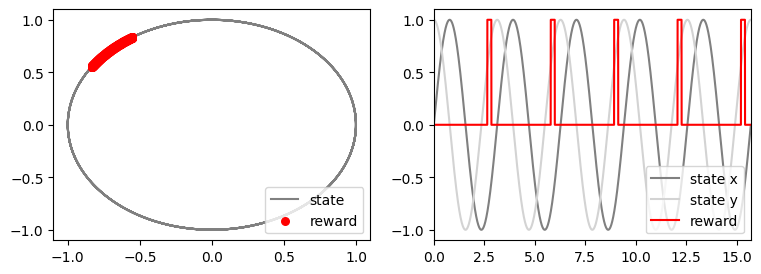

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys,os
sys.path.insert(1, os.path.dirname(os.getcwd()))

## Very simple RL problem for testing: Go around a circle and get reward at particular spots
# The state is (x,y) position 
T=np.pi*5
dt = 0.001
timesteps = np.arange(0,T,dt)

def sim_fun(t):
    return np.stack([np.sin(t*2), np.cos(t*2)]).T
sim_path = sim_fun(timesteps)

def reward_fun(t):
    if isinstance(t, np.ndarray):
        rewards = np.zeros(len(t))
        rewards[np.sqrt(np.sum((sim_fun(t) - np.array([-0.707,0.707]))**2,axis=1)) < 0.2] = 1
    else:
        rewards = 1 if (np.sqrt(np.sum((sim_fun(t) - np.array([-0.707,0.707]))**2)) < 0.2) else 0
    return rewards

rewards = reward_fun(timesteps)

plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.plot(sim_path[:,0],sim_path[:,1], label='state',zorder=1,color='grey')
plt.scatter(sim_path[rewards>0,0], sim_path[rewards>0,1], label='reward',s=30,zorder=2, color='red')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(timesteps,sim_path[:,0], label='state x',color='grey')
plt.plot(timesteps,sim_path[:,1], label='state y',color='lightgrey')
plt.plot(timesteps,rewards, label='reward', color='red')
plt.xlim([0,T])
plt.legend(loc='lower right')

As a baseline comparison, we can estimate the value function via returns:

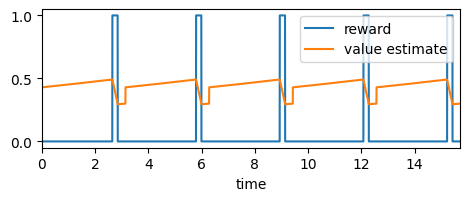

In [2]:
# solution via computing returns
discount  =0.95
returns = [dt*np.sum(discount**(dt*np.arange(len(rewards)-i))*rewards[i:]) for i in range(len(rewards))]

n_period = int(np.pi/dt)
vals_direct=[np.mean([returns[j*n_period + i] for j in range(5)]) for i in range(n_period)]
repeated_vals = np.tile(vals_direct,int(T/np.pi))

plt.figure(figsize=(5.4,1.8))
plt.plot(timesteps,rewards, label='reward')
plt.plot(timesteps[:len(repeated_vals)],repeated_vals, label='value estimate')
plt.xlim([0,T])
plt.xlabel('time')
plt.legend()

We want our model to produce similar output - at the very least something with a similar shape. Note that our agent only sees the reward area three times before learning is turned off so it's output won't be perfect.

In [3]:
import nengo
from online_rl_networks import ValueCritic, sparsity_to_x_intercept

n_neurons_state=200
n_neurons_value=100
discount = 0.95
theta = 0.5

q_a = 8
q_r = 8
q_v = 8


model = nengo.Network()
with model:
    # State function
    state = nengo.Node(sim_fun)
    # Reward function
    reward = nengo.Node(reward_fun)
    # Note that for a complete RL system with action selection, these functions would take input from an actor

    # Input to ValueCritic:
    # n_neurons_state: number of neurons in state pop
    # n_neurons_value: number of neurons in value pop
    # theta: length of memories
    # d:  dim of state (=2 here)
    # discount: gamma in TD rules
    # q_a, q_r, q_v: dim of LMU state for each memory (higher means better memory of high freq signals)
    # algor: The TD tule to use(can be 'TD0', 'TDtheta', 'TDlambda'). We use TD0 here
    # T_test: after this time, stop learning
    # learning_rate: of PES rule
    VL = ValueCritic(n_neurons_state,n_neurons_value, theta, 2, discount, q_a, q_r, q_v,'TD0',
                     T_test=9,learning_rate=1e-4,intercepts=nengo.dists.Choice([sparsity_to_x_intercept(2, 0.1)]))
    nengo.Connection(state, VL.state_input, synapse=None)
    nengo.Connection(reward, VL.reward_input, synapse=None)
    
    V_p = nengo.Probe(VL.value, synapse=.05)
    Vmem_p = nengo.Probe(VL.value_memory, synapse=None)
    r_p = nengo.Probe(reward, synapse=None)
    rmem_p = nengo.Probe(VL.reward_memory, synapse=None)
    stateact_p = nengo.Probe(VL.state.neurons, synapse=0.005)
    stateactmem_p = nengo.Probe(VL.state_memory, synapse=None)
    er_p = nengo.Probe(VL.rule, "error", synapse=None)
    

with nengo.Simulator(model,dt=dt) as sim:
    sim.run(T)
ts = sim.trange() 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 0, 'Time (s)')

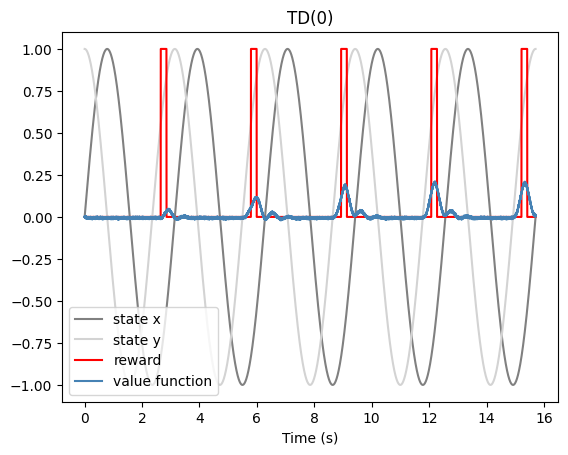

In [4]:
plt.figure()
plt.plot(timesteps,sim_path[:,0], label='state x',color='grey')
plt.plot(timesteps,sim_path[:,1], label='state y',color='lightgrey')
plt.plot(timesteps,rewards, label='reward', color='red')
plt.plot(timesteps, sim.data[V_p], color='steelblue', label='value function')
plt.legend()
plt.title('TD(0)')
plt.xlabel('Time (s)')
# note that learning is turned off after 9 seconds

It learns to anticipate the reward when it gets close to the goal state, but it wasn't given enough time to propagate the TD error too far back. Let's try running the model longer:

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 0, 'Time (s)')

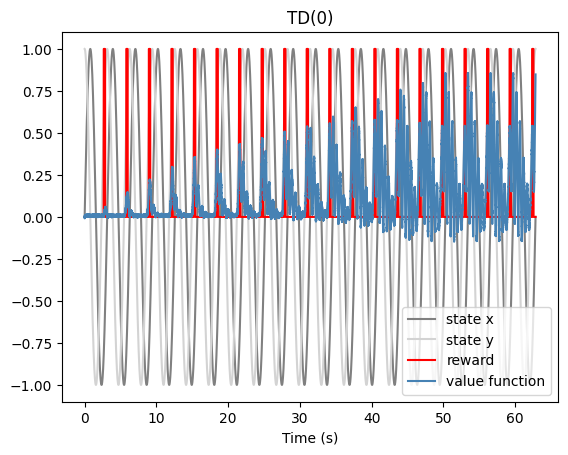

In [7]:
model = nengo.Network()
with model:
    state = nengo.Node(sim_fun)
    reward = nengo.Node(reward_fun)
    VL = ValueCritic(n_neurons_state,n_neurons_value, theta, 2, discount, q_a, q_r, q_v,'TD0',
                     T_test=15*np.pi,learning_rate=1e-4, intercepts=nengo.dists.Choice([sparsity_to_x_intercept(2, 0.1)]))
    nengo.Connection(state, VL.state_input, synapse=None)
    nengo.Connection(reward, VL.reward_input, synapse=None)
    
    V_p = nengo.Probe(VL.value, synapse=.05)
    

with nengo.Simulator(model,dt=dt) as sim:
    sim.run(np.pi*20)
ts = sim.trange() 

plt.figure()
plt.plot(ts,sim_fun(ts)[:,0], label='state x',color='grey')
plt.plot(ts,sim_fun(ts)[:,1], label='state y',color='lightgrey')
plt.plot(ts,reward_fun(ts), label='reward', color='red')
plt.plot(ts, sim.data[V_p], color='steelblue', label='value function')
plt.legend()
plt.title('TD(0)')
plt.xlabel('Time (s)')

The value estimate grows and oscillates wildly. It is known that RL can be unstable when neural networks are used for function approximation. Convergence is not guaranteed and network output can oscillate or diverge, due to high correlation between actions and states & and bootstramp nature of TD learning. This is why replay memory and target networks are often used. We are learning online and without perfect weight sharing/copying (as would be needed for a target network). Instead to avoid these oscillations we can reduce the learning rate or use other learning rules. See the TD(theta) notebook for a stable long run.